In [51]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import jax

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import numpyro
import numpy as np 

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive





In [52]:
garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), np.concatenate(yini).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, G_GAIA, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), np.concatenate(MeH).reshape(-1, 1)])



In [53]:


# Flattening the list of arrays into a single array
all_ages = np.concatenate(ages)
all_massini = np.concatenate(massini)
all_fehini = np.concatenate(fehini)
all_alphamlt = np.concatenate(alphamlt)
all_yini = np.concatenate(yini)
all_eta = np.concatenate(eta)
all_alphafe = np.concatenate(alphafe)

# Function to calculate overall statistics
def calculate_overall_stats(data):
    return {
        "min": float(np.min(data)),
        "max": float(np.max(data)),
        "mean": float(np.mean(data)),
    }

# Calculate overall statistics for each parameter
overall_ages_stats = calculate_overall_stats(all_ages)
overall_massini_stats = calculate_overall_stats(all_massini)
overall_fehini_stats = calculate_overall_stats(all_fehini)
overall_alphamlt_stats = calculate_overall_stats(all_alphamlt)
overall_yini_stats = calculate_overall_stats(all_yini)
overall_eta_stats = calculate_overall_stats(all_eta)
overall_alphafe_stats = calculate_overall_stats(all_alphafe)

# Print overall statistics
print("Overall Statistics:")
print(f"Ages: {overall_ages_stats}")
print(f"Massini: {overall_massini_stats}")
print(f"FeHini: {overall_fehini_stats}")
print(f"AlphaMLT: {overall_alphamlt_stats}")
print(f"Yini: {overall_yini_stats}")
print(f"Eta: {overall_eta_stats}")
print(f"AlphaFe: {overall_alphafe_stats}")


Overall Statistics:
Ages: {'min': 827.4848204, 'max': 19999.94418, 'mean': 6248.27032430789}
Massini: {'min': 0.702, 'max': 1.5, 'mean': 1.1271572095586435}
FeHini: {'min': -1.99785156, 'max': 0.196508789, 'mean': -0.8123048807663267}
AlphaMLT: {'min': 1.50004883, 'max': 2.29716797, 'mean': 1.9114640387833655}
Yini: {'min': 0.220047607, 'max': 0.349730225, 'mean': 0.2825130091672598}
Eta: {'min': 0.000219726562, 'max': 0.298901367, 'mean': 0.1469626098259149}
AlphaFe: {'min': -0.2, 'max': 0.6, 'mean': 0.21327052500066052}


In [54]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [55]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 64)
        self.dense6 = nn.Linear(64, 8)    # Output layer
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)
        return x

    
# Load the pre-trained model weights
model = GarstecNet()
model.load_state_dict(torch.load('garstec_model_V3_state.pth'))

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Dell\AppData\Local\Temp\ipykernel_11504\3765155684.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('garstec_model_V3_state.pth

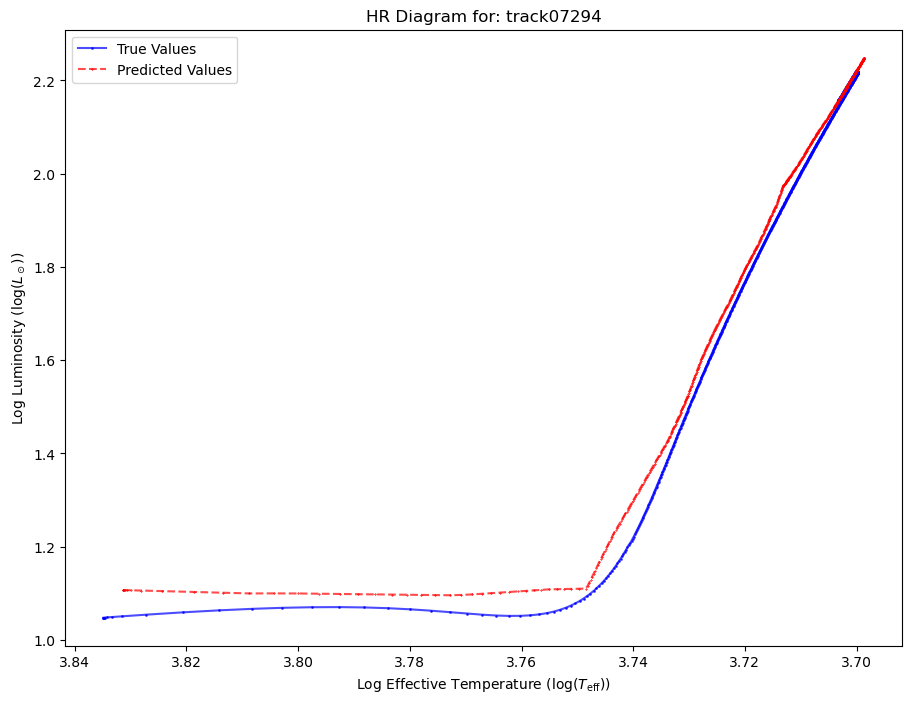

In [56]:
import jax.numpy as jnp
import h5py
import torch
import matplotlib.pyplot as plt

# Plotting for neural network and garstec track: 07294
specific_track_name = 'track07294'

# Retrieve all required inputs for track 07294
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = jnp.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Outputs
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]
    dnufit_specific = specific_track['dnufit'][:]
    FeH_specific = specific_track['FeH'][:]
    G_GAIA_specific = specific_track['G_GAIA'][:]
    massfin_specific = specific_track['massfin'][:]
    numax_specific = specific_track['numax'][:]
    MeH_specific = specific_track['MeH'][:]



# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]

# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Convert `all_features` to numpy array before scaling
all_features_numpy = np.array(all_features)  # Convert to numpy for scaling


all_features_scaled = scaler_X.transform(all_features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific1 = model(all_features_tensor).numpy()  # Make predictions
    predictions_specific = scaler_y.inverse_transform(predictions_specific1)  # Inverse transform
# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]



# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()



In [57]:
def emulate_with_pytorch(x, model, scaler_X, scaler_y):
    # Normalize inputs
    x_numpy = np.array(jax.device_get(x))

    x_scaled = scaler_X.transform(x_numpy)  # Apply input scaling

    # Convert to PyTorch tensor
    x_tensor = torch.FloatTensor(x_scaled)

    # Pass through PyTorch model
    model.eval()
    with torch.no_grad():
        y_specific = model(x_tensor).numpy()  # Assuming model output is NumPy array
        

    # Inverse scaling of the output
    y_specific = scaler_y.inverse_transform(y_specific)

    y = jnp.array(y_specific)  # Convert NumPy array to JAX array

    return y_specific 
    

In [58]:

state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x





In [59]:
obs = {
    'teff': teff_specific,
    'lum': luminosity_specific,
    'dnu': dnufit_specific,
    'feh': FeH_specific,
    'gaia': G_GAIA_specific,
    'mass': massfin_specific,
    'numax': numax_specific,
    'meh': MeH_specific
}


Overall Statistics:
Ages: {'min': 827.4848204, 'max': 19999.94418, 'mean': 6248.27032430789}
Massini: {'min': 0.702, 'max': 1.5, 'mean': 1.1271572095586435}
FeHini: {'min': -1.99785156, 'max': 0.196508789, 'mean': -0.8123048807663267}
AlphaMLT: {'min': 1.50004883, 'max': 2.29716797, 'mean': 1.9114640387833655}
Yini: {'min': 0.220047607, 'max': 0.349730225, 'mean': 0.2825130091672598}
Eta: {'min': 0.000219726562, 'max': 0.298901367, 'mean': 0.1469626098259149}
AlphaFe: {'min': -0.2, 'max': 0.6, 'mean': 0.21327052500066052}

[4145.349646, 1.107, 2.02275391, 0.0366577148, 0.245723877, -1.15539551, -0.2]


In [98]:
def Bmodel(obs=None):
    # Define priors
    ages_ = numpyro.sample("ages_s", dist.Uniform(2500, 10000))  
    massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(2, 2)) + 0.7)
    fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2.0)
    alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(2, 2)) + 1.5)
    yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 2)) + 0.22)
    eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 2)))
    alphafe_ = numpyro.deterministic("alphafe_", 0.8 * numpyro.sample("alphafe_s", dist.Beta(2, 2)) - 0.2)

    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, alphafe_]
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.stack(log_transformed_inputs + [fehini_, yini_], axis=-1)

    # Scale x manually
    mean_x = scaler_X.mean_
    scale_x = scaler_X.scale_  
    x_scaled = (x - mean_x) / scale_x

    # Emulate using PyTorch model
    y_scaled = emulate(x_scaled) # , model, scaler_X, scaler_y
    
    # De-scale y manually 
    mean_y = jnp.array(scaler_y.mean_)  
    std_y = jnp.array(scaler_y.scale_)
    y = y_scaled * std_y + mean_y
    
    # Extract predictions
    teff, lum, dnu, feh, gaia, mass, numax, meh = (
        10**y[:, 0], 10**y[:, 1], 10**y[:, 2], y[:, 3], 10**y[:, 4], 10**y[:, 5], 10**y[:, 6], y[:, 7]
    )

    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, 70), obs=teff_specific)
        numpyro.sample("lum_obs", dist.StudentT(5, lum, 10), obs=luminosity_specific)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, 0.8), obs=dnufit_specific)
        #numpyro.sample("feh_obs", dist.StudentT(5, feh, 0.02), obs=FeH_specific)
        #numpyro.sample("gaia_obs", dist.StudentT(5, gaia, 0.01), obs=G_GAIA_specific)
        #numpyro.sample("mass_obs", dist.StudentT(5, mass, 0.6), obs=massfin_specific)#
        numpyro.sample("numax_obs", dist.StudentT(5, numax, 0.02), obs=numax_specific)
        numpyro.sample("meh_obs", dist.StudentT(5, meh, 0.02), obs=MeH_specific)



## Prior check

In [61]:
from jax import random

nuts_kernel = NUTS(Bmodel)

prior_mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
prior_mcmc.run(rng_key)

posterior_samples = prior_mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:04<00:00, 998.60it/s, 7 steps of size 5.71e-01. acc. prob=0.92]  


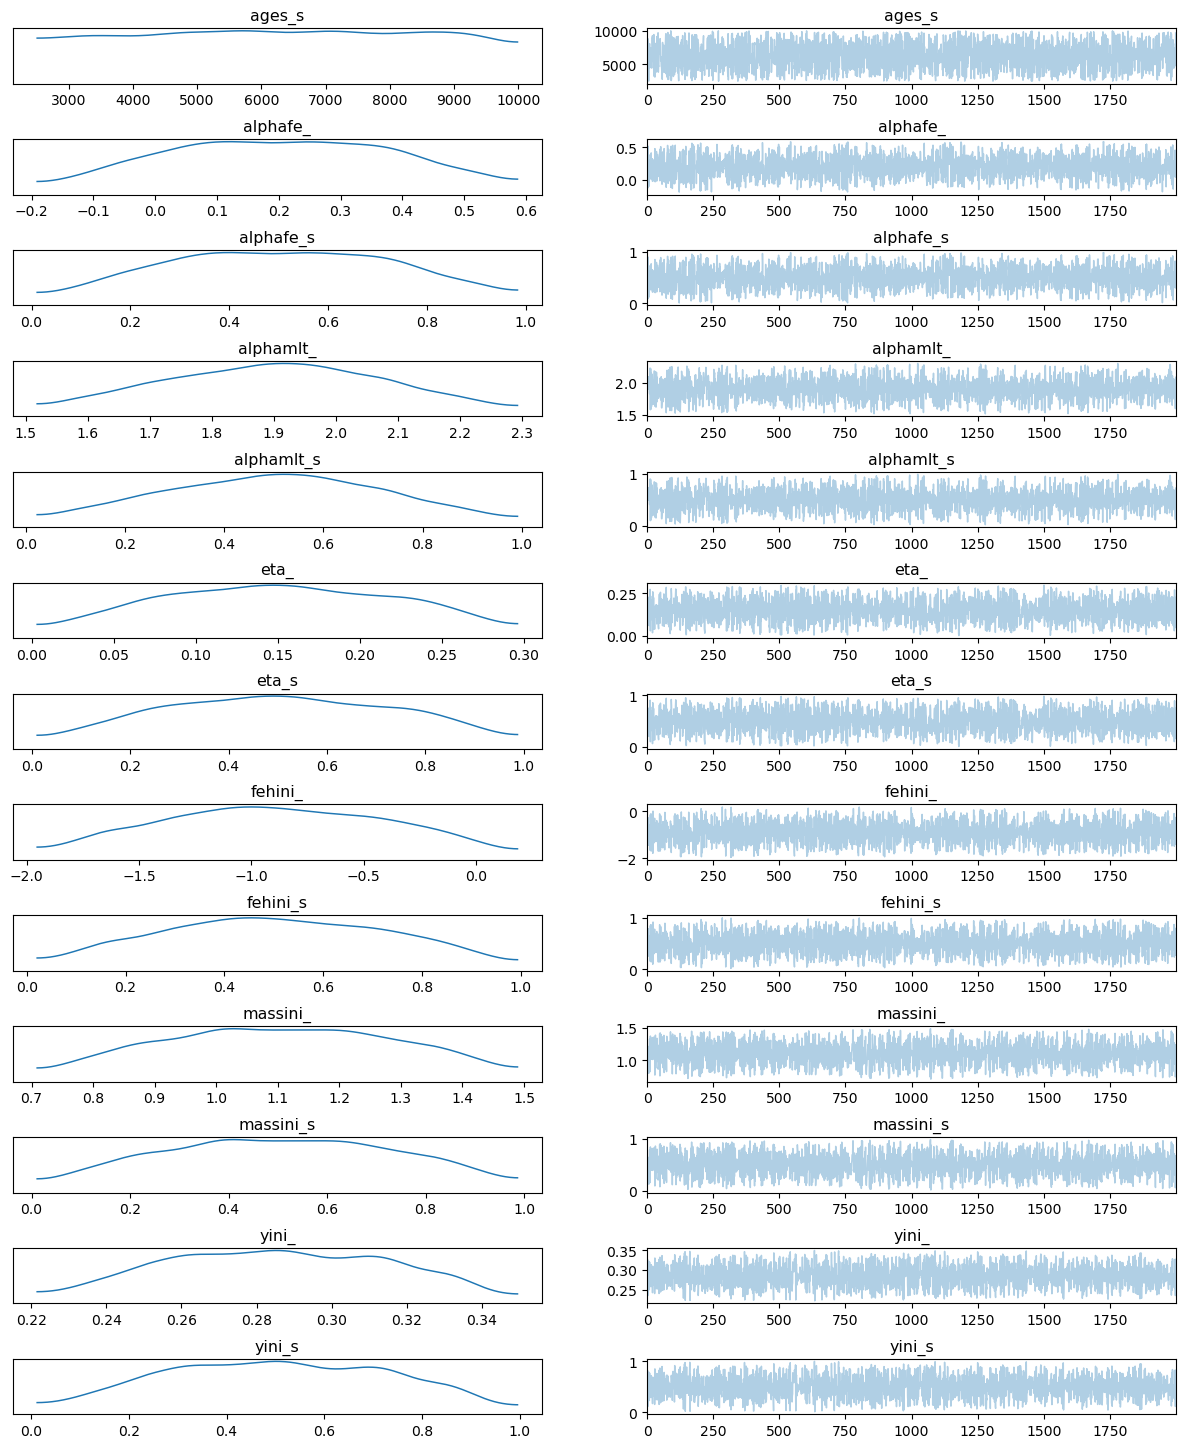

In [62]:
import arviz as az

prior_trace = az.from_numpyro(prior_mcmc)
az.plot_trace(prior_trace, compact=False, figsize=(15, 18));  

plt.subplots_adjust(hspace=1)  

In [99]:

from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=2)
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=1)

C:\Users\Dell\AppData\Local\Temp\ipykernel_11504\688129392.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=2)


[2376.5254]
[2122.4504]
Traced<ShapedArray(float32[1])>with<JVPTrace> with
  primal = Array([2122.4504], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x0000023A014B16C0>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace>, Traced<ShapedArray(float32[1]):JaxprTrace>), out_tracer_refs=[<weakref at 0x00000239E6ECFC40; to 'JaxprTracer' at 0x00000239E6ECD850>], out_avals=[ShapedArray(float32[1])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1] b:f32[1]. let c:f32[1] = mul a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': '_power', 'keep_unused': False, 'inline': True, 'compiler_options_kvs': ()}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x0000023A01

  0%|          | 0/2000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[1])>with<JVPTrace> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x0000023A014B3750>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace>, Traced<ShapedArray(float32[1]):JaxprTrace>), out_tracer_refs=[<weakref at 0x00000239E7950360; to 'JaxprTracer' at 0x00000239E7952980>], out_avals=[ShapedArray(float32[1])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1] b:f32[1]. let c:f32[1] = mul a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': '_power', 'keep_unused': False, 'inline': True, 'compiler_options_kvs': ()}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x00000239E7CE1

sample: 100%|██████████| 2000/2000 [03:44<00:00,  8.91it/s, 1023 steps of size 5.70e-04. acc. prob=0.92]


[1446.8683]
[1915.4293]
Traced<ShapedArray(float32[1])>with<JVPTrace> with
  primal = Array([1915.4293], dtype=float32)
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x0000023A014B1470>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace>, Traced<ShapedArray(float32[1]):JaxprTrace>), out_tracer_refs=[<weakref at 0x00000239D53AEFC0; to 'JaxprTracer' at 0x00000239D53AD990>], out_avals=[ShapedArray(float32[1])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[1] b:f32[1]. let c:f32[1] = mul a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': '_power', 'keep_unused': False, 'inline': True, 'compiler_options_kvs': ()}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x00000239E7

sample: 100%|██████████| 2000/2000 [03:11<00:00, 10.44it/s, 1023 steps of size 3.88e-04. acc. prob=0.65]


In [100]:
trace = az.from_numpyro(mcmc)

print("\nR-hat values:")
print(mcmc.get_extra_fields()["diverging"].mean())  # Check for divergences
print(az.rhat(trace))

# Check the parameter ranges actually explored
for param in ['ages_s', 'massini_s', 'fehini_s', 'alphamlt_s', 'yini_s', 'eta_s', 'alphafe_s']:
    values = trace.posterior[param].values
    print(f"\n{param}:")
    print(f"Range: [{values.min():.3f}, {values.max():.3f}]")
    print(f"Mean ± Std: {values.mean():.3f} ± {values.std():.3f}")

[15417892.]
Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace>

R-hat values:
0.0
<xarray.Dataset>
Dimensions:     ()
Data variables: (12/13)
    ages_s      float64 2.475
    alphafe_    float64 1.801
    alphafe_s   float64 1.801
    alphamlt_   float64 1.911
    alphamlt_s  float64 1.911
    eta_        float64 2.125
    ...          ...
    fehini_     float64 2.421
    fehini_s    float64 2.421
    massini_    float64 2.639
    massini_s   float64 2.639
    yini_       float64 2.173
    yini_s      float64 2.173

ages_s:
Range: [4712.789, 7111.032]
Mean ± Std: 6160.165 ± 938.715

massini_s:
Range: [0.244, 0.530]
Mean ± Std: 0.364 ± 0.116

fehini_s:
Range: [0.103, 0.451]
Mean ± Std: 0.281 ± 0.168

alphamlt_s:
Range: [0.514, 0.886]
Mean ± Std: 0.692 ± 0.153

yini_s:
Range: [0.004, 0.736]
Mean ± Std: 0.379 ± 0.338

eta_s:
Range: [0.362, 0.479]
Mean ± Std: 0.428 ± 0.035

alphafe_s:
Range: [0.785, 0.973]
Mean ± Std: 0.826 ± 0.037


In [101]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_s,6160.165,938.950,4843.070,7111.032,657.074,555.732,2.0,12.0,2.47
alphafe_,0.461,0.030,0.428,0.521,0.016,0.012,3.0,11.0,1.80
alphafe_s,0.826,0.037,0.785,0.902,0.020,0.016,3.0,11.0,1.80
alphamlt_,2.054,0.123,1.925,2.197,0.086,0.073,3.0,26.0,1.91
alphamlt_s,0.692,0.153,0.531,0.871,0.108,0.091,3.0,26.0,1.91
eta_,0.128,0.010,0.109,0.140,0.007,0.005,3.0,11.0,2.12
eta_s,0.428,0.035,0.362,0.467,0.022,0.018,3.0,11.0,2.12
fehini_,-1.381,0.369,-1.760,-1.007,0.260,0.220,2.0,11.0,2.42
fehini_s,0.281,0.168,0.109,0.451,0.118,0.100,2.0,11.0,2.42
massini_,0.991,0.093,0.895,1.105,0.065,0.055,2.0,12.0,2.64


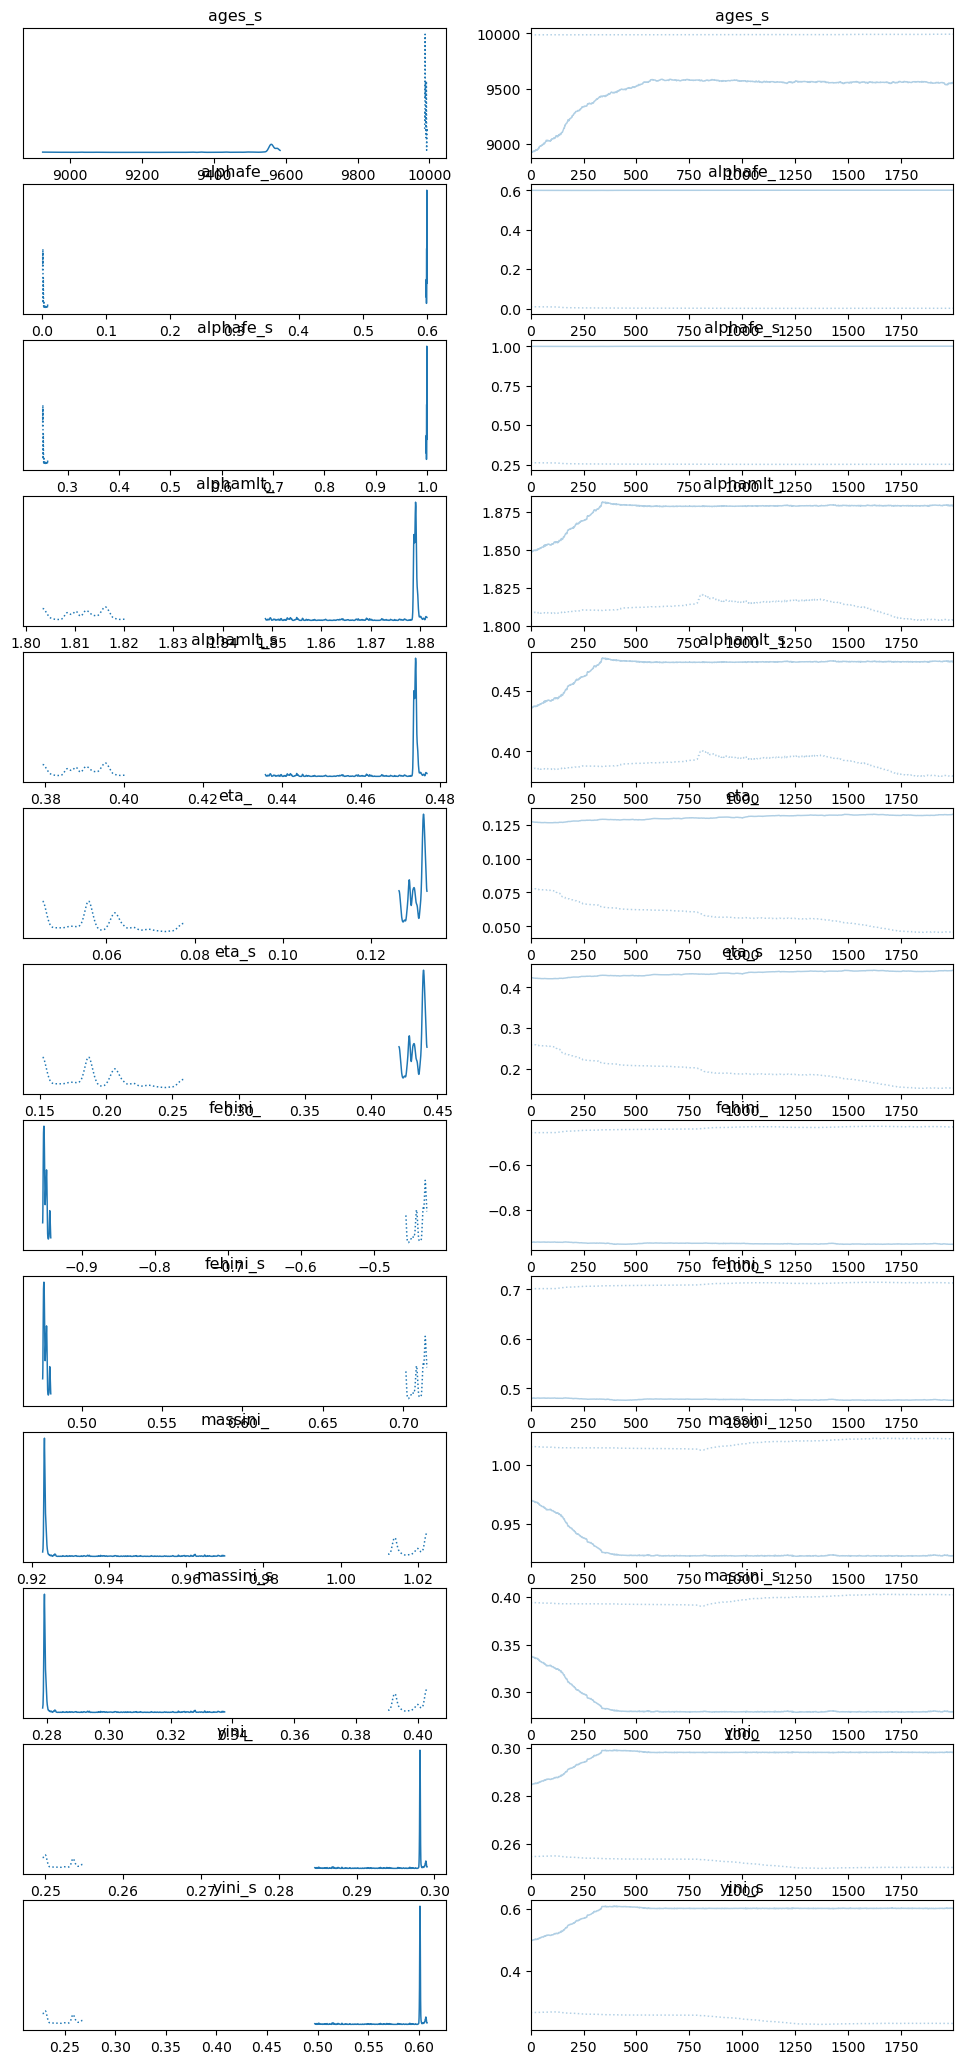

In [80]:
az.plot_trace(trace);

In [66]:
# Setting truth values for corner plot
truth_values = [ages[0].item(), massini[0].item(), alphamlt[0].item(), eta[0].item(), yini[0].item(),  fehini[0].item(), alphafe[0].item()]
print(truth_values)

[4145.349646, 1.107, 2.02275391, 0.0366577148, 0.245723877, -1.15539551, -0.2]


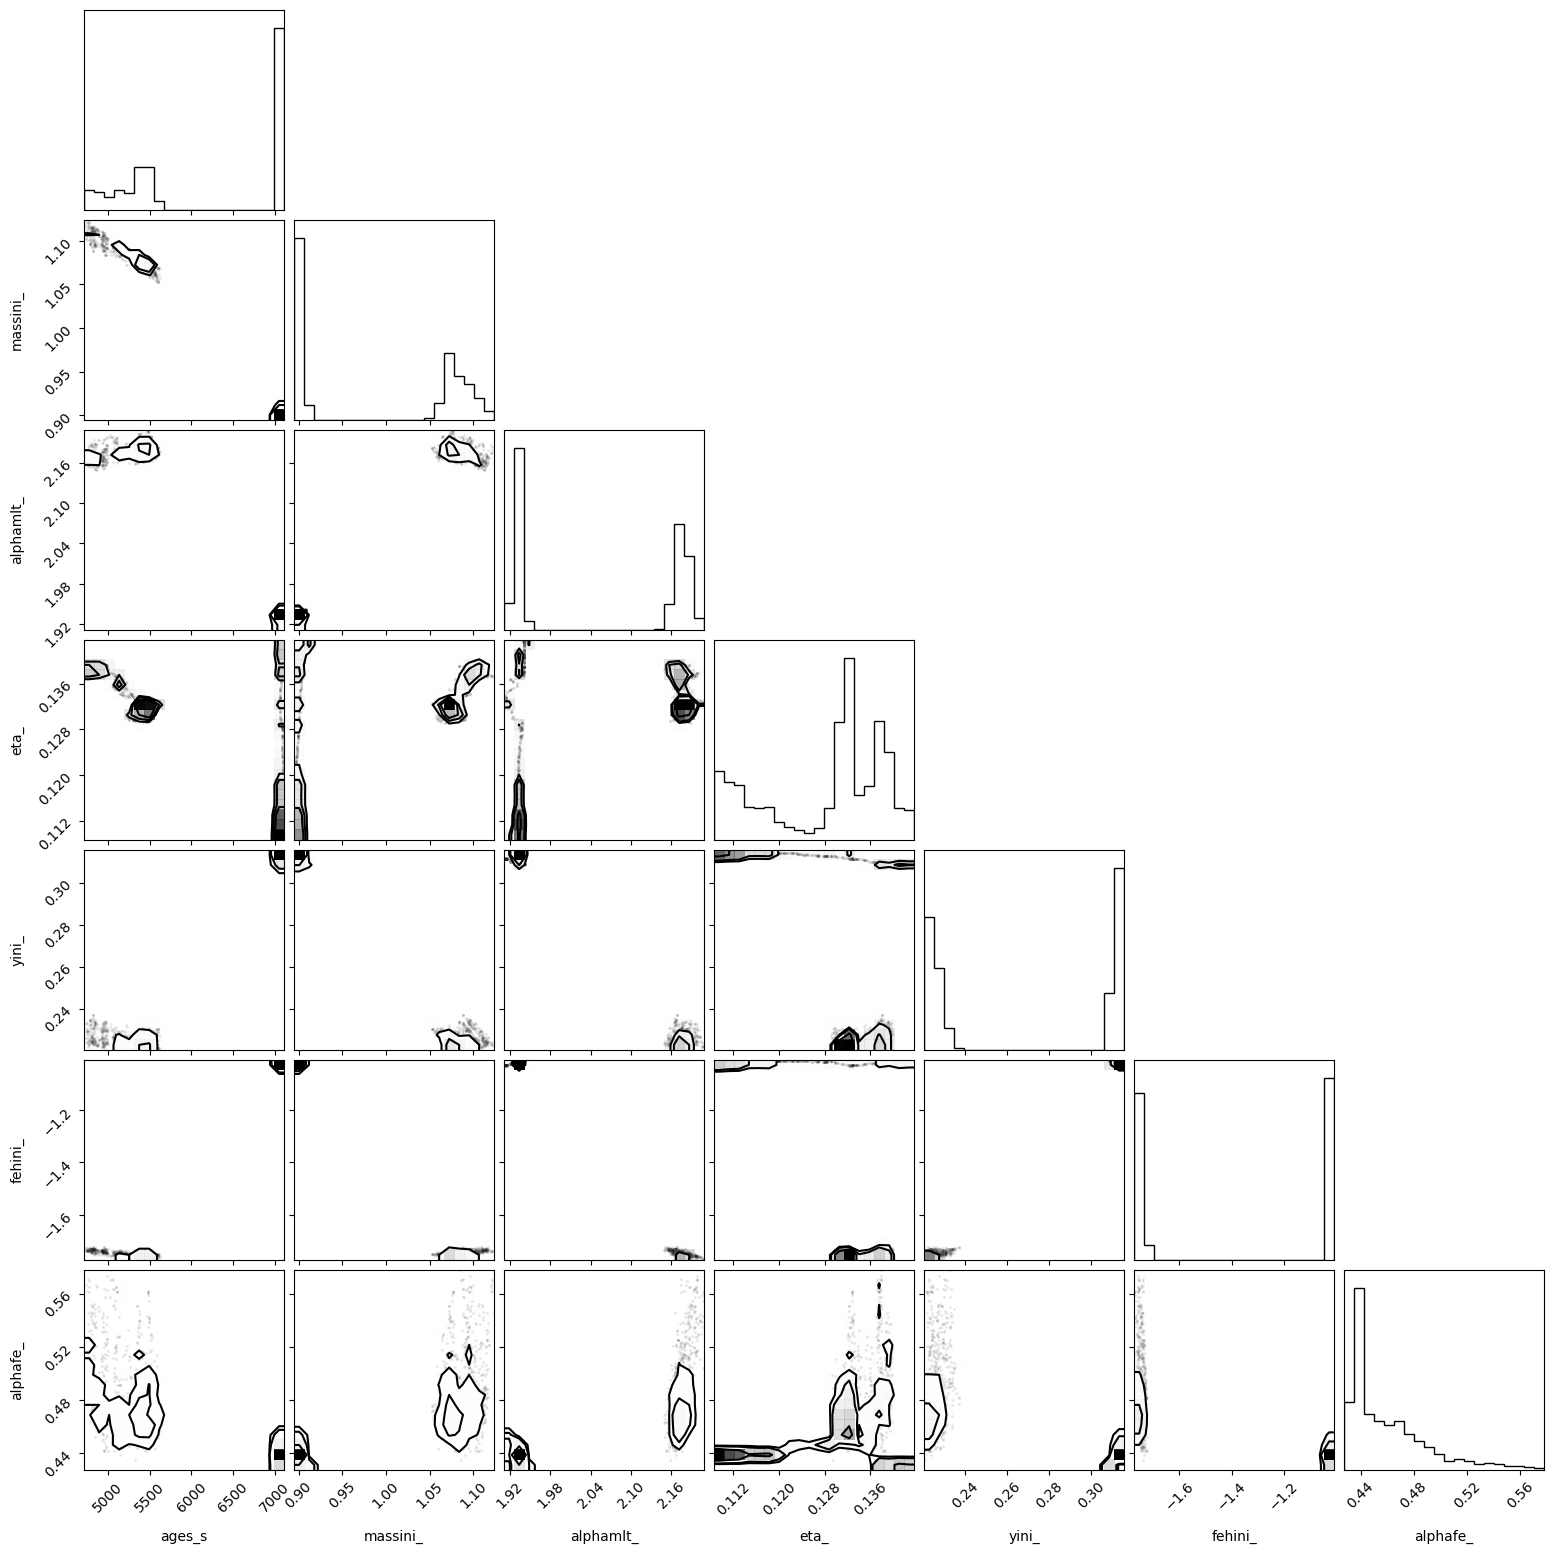

In [102]:
import corner

corner.corner(trace, var_names=['ages_s', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             );

In [103]:
from sklearn.preprocessing import MinMaxScaler


# Extract the variables from the trace
ages_samples = trace.posterior['ages_s'].values.flatten()
mass_samples = trace.posterior['massini_'].values.flatten()
mlt_samples = trace.posterior['alphamlt_'].values.flatten()
eta_samples = trace.posterior['eta_'].values.flatten()
yini_samples = trace.posterior['yini_'].values.flatten()
fehini_samples = trace.posterior['fehini_'].values.flatten()
fe_samples = trace.posterior['alphafe_'].values.flatten()



# sample 910 values from the model:

# Length of the ages_samples
n_samples = len(ages_samples)

# Indices of the minimum and maximum values
min_idx = np.argmin(ages_samples)
max_idx = np.argmax(ages_samples)

# If ages_samples is long enough, we'll divide the remaining range into even intervals
# Calculate the total number of intervals (excluding the min and max)
num_intervals = 910 - 2  # Subtract 2 because min and max are already selected

# Calculate step size for evenly spaced sampling
step = (n_samples - 1) // num_intervals  # This will give us roughly equal intervals

# Generate the indices for evenly spaced sampling, including min and max
evenly_spaced_indices = [min_idx, max_idx]  # Start with min and max indices
for i in range(1, num_intervals + 1):
    idx = i * step
    evenly_spaced_indices.append(idx)

# Sort the indices to ensure they're in ascending order
ages_indices = np.sort(evenly_spaced_indices)

# Subsample all variables
ages_subsample = np.sort(ages_samples[ages_indices]).reshape(-1, 1)
mass_subsample = np.full(910, np.mean(mass_samples)).reshape(-1, 1)
mlt_subsample = np.full(910, np.mean(mlt_samples)).reshape(-1, 1)
eta_subsample = np.full(910, np.mean(eta_samples)).reshape(-1, 1)
yini_subsample = np.full(910, np.mean(yini_samples)).reshape(-1, 1)
fehini_subsample = np.full(910, np.mean(fehini_samples)).reshape(-1, 1)
fe_subsample = np.full(910, np.mean(fe_samples)).reshape(-1, 1)

epsilon = 1e-10
log10_hbm_inputs = [ages_subsample, mass_subsample, mlt_subsample, eta_subsample, fe_subsample]
log10_transformed_hbm_inputs = [np.log10(np.maximum(data, epsilon)) for data in log10_hbm_inputs]


# Combine log-transformed inputs with raw `fehini` and `yini`
features = np.hstack(log10_transformed_hbm_inputs + [fehini_subsample, yini_subsample])

features_numpy = np.array(features)  # Convert to numpy for scaling

features_scaled = scaler_X.transform(features_numpy)  # Apply scaler

# Convert scaled inputs to PyTorch tensor

features_tensor = torch.FloatTensor(features_scaled)

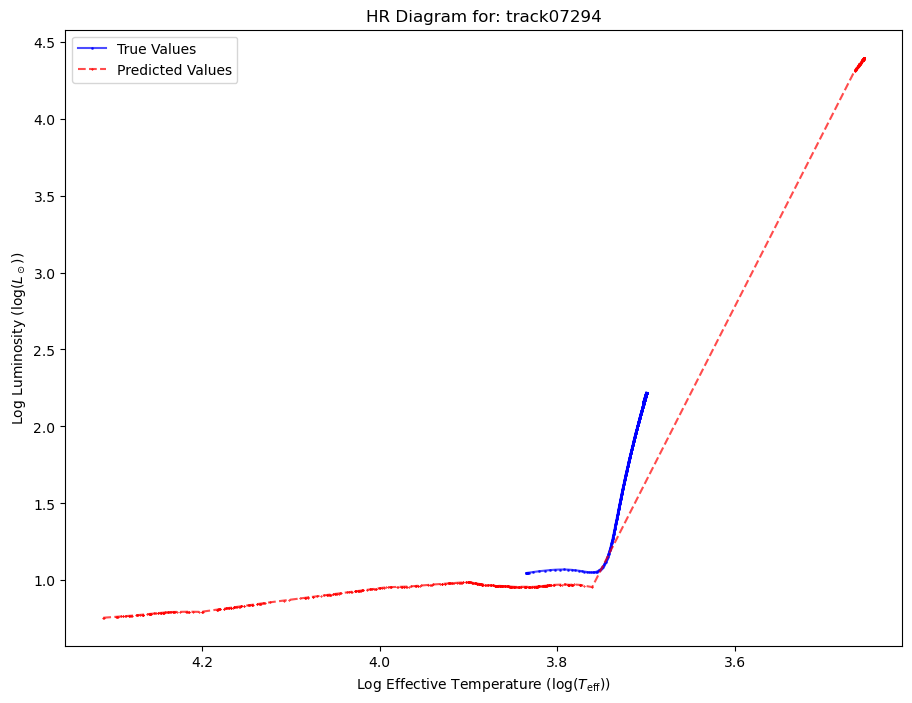

In [104]:
model.eval()
with torch.no_grad():
    predictions_hbm = model(features_tensor).numpy()  # Make predictions
    predictions_hbm1 = scaler_y.inverse_transform(predictions_hbm)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
hbm_teff = 10**predictions_hbm1[:, 0]  # Inverse log10 transformation
hbm_luminosity = 10**predictions_hbm1[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_hbm_teff = np.log10(hbm_teff)
log_hbm_luminosity = np.log10(hbm_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_hbm_teff, log_hbm_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()